In [1]:
import sys
from decimal import ROUND_HALF_UP, Decimal

import numpy as np
import pandas as pd
from lightgbm import Booster, LGBMRegressor
from tqdm import tqdm

In [2]:
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def generate_adjusted_close(df):
    """
    Args:
        df (pd.DataFrame)  : stock_price for a single SecuritiesCode
    Returns:
        df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
    """
    # sort data to generate CumulativeAdjustmentFactor
    df = df.sort_values("Date", ascending=False)
    # generate CumulativeAdjustmentFactor by taking the cumulative product of AdjustmentFactor
    df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
    # generate AdjustedClose
    df.loc[:, "AdjustedClose"] = (
        df["CumulativeAdjustmentFactor"] * df["Close"]
    ).map(lambda x: float(
        Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
    ))
    # reverse order
    df = df.sort_values("Date")
    # to fill AdjustedClose, replace 0 into np.nan
    df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
    # forward fill AdjustedClose
    df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
    return df

In [6]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # copy to edit
    price = price.copy()
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

In [7]:
df_price = reduce_memory_usage(pd.read_csv("../../../data/train_files/stock_prices.csv"))
df_price_supplemental = reduce_memory_usage(pd.read_csv("../../../data/supplemental_files/stock_prices.csv"))
df_price = pd.concat([df_price, df_price_supplemental])
df_price = adjust_price(df_price)

Memory usage of dataframe is 197.98 MB
Memory usage after optimization is: 102.33 MB
Decreased by 48.3%
Memory usage of dataframe is 22.91 MB
Memory usage after optimization is: 11.84 MB
Decreased by 48.3%


In [40]:
print(df_price.head())

                    RowId  SecuritiesCode    Open    High     Low   Close  \
Date                                                                        
2017-01-04  20170104_1301            1301  2734.0  2755.0  2730.0  2742.0   
2017-01-05  20170105_1301            1301  2743.0  2747.0  2735.0  2738.0   
2017-01-06  20170106_1301            1301  2734.0  2744.0  2720.0  2740.0   
2017-01-10  20170110_1301            1301  2745.0  2754.0  2735.0  2748.0   
2017-01-11  20170111_1301            1301  2748.0  2752.0  2737.0  2745.0   

            Volume  AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Date                                                                      
2017-01-04   31400               1.0               NaN              0.0   
2017-01-05   17900               1.0               NaN              0.0   
2017-01-06   19900               1.0               NaN              0.0   
2017-01-10   24200               1.0               NaN              0.0   
2017-01-11

In [8]:
def get_features_for_predict(price, code):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    close_col = "AdjustedClose"
    feats = price.loc[price["SecuritiesCode"] == code, ["SecuritiesCode", close_col]].copy()

    feats["close_diff1"] = feats[close_col].diff(1)

    # filling data for nan and inf
    feats = feats.fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)
    # drop AdjustedClose column
    feats = feats.drop([close_col], axis=1)

    return feats

In [9]:
# fetch prediction target SecuritiesCodes
codes = sorted(df_price["SecuritiesCode"].unique())

# generate feature
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(df_price, code)
    buff.append(feat)
feature = pd.concat(buff)


100%|██████████| 2000/2000 [00:29<00:00, 67.36it/s]


In [10]:
def get_label(price, code):
    """ Labelizer
    Args:
        price (pd.DataFrame): dataframe of stock_price.csv
        code (int): Local Code in the universe
    Returns:
        df (pd.DataFrame): label data
    """
    df = price.loc[price["SecuritiesCode"] == code].copy()
    df.loc[:, "label"] = df["Target"]

    return df.loc[:, ["SecuritiesCode", "label"]]

In [11]:
TRAIN_END = "2019-12-31"
# We put a week gap between TRAIN_END and TEST_START
# to avoid leakage of test data information from label
TEST_START = "2020-01-06"

def get_features_and_label(price, codes, features):
    """
    Args:
        price (pd.DataFrame): loaded price data
        codes  (array) : target codes
        feature (pd.DataFrame): features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

       # generate feature one by one
    for code in tqdm(codes):

        feats = features[features["SecuritiesCode"] == code].dropna()
        labels = get_label(price, code).dropna()

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]

            assert (labels.loc[:, "SecuritiesCode"] == feats.loc[:, "SecuritiesCode"]).all()
            labels = labels.loc[:, "label"]
            # split data into TRAIN and TEST
            _train_X = feats[: TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[: TRAIN_END]
            _test_y = labels[TEST_START:]
            
            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)
           # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)
            
    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y

In [12]:
# generate feature/label
train_X, train_y, test_X, test_y = get_features_and_label(
    df_price, codes, feature)

100%|██████████| 2000/2000 [00:58<00:00, 34.06it/s]


In [13]:
print(train_X.head())

            SecuritiesCode  close_diff1
Date                                   
2017-01-04            1301          0.0
2017-01-05            1301         -4.0
2017-01-06            1301          2.0
2017-01-10            1301          8.0
2017-01-11            1301         -3.0


In [19]:
from sklearn import tree
feat_cols= ["close_diff1"]
model = tree.DecisionTreeRegressor(criterion="squared_error", min_samples_leaf=2)
model = model.fit(train_X[feat_cols].values, train_y)
result = test_X[["SecuritiesCode"]].copy()
result.loc[:, "predict"] =  model.predict(test_X[feat_cols])
result.loc[:, "Target"] = test_y.values
print(result.head())

c:\Anaconda\envs\OR_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


            SecuritiesCode   predict    Target
Date                                          
2020-01-06            1301  0.000655  0.001725
2020-01-07            1301  0.000265  0.010338
2020-01-08            1301  0.000611 -0.000341
2020-01-09            1301  0.000093 -0.006481
2020-01-10            1301  0.000565  0.007553


In [25]:
print(result[result["SecuritiesCode"] == 1301])

            SecuritiesCode   predict    Target
Date                                          
2020-01-06            1301  0.000655  0.001725
2020-01-07            1301  0.000265  0.010338
2020-01-08            1301  0.000611 -0.000341
2020-01-09            1301  0.000093 -0.006481
2020-01-10            1301  0.000565  0.007553
...                    ...       ...       ...
2022-06-20            1301  0.000269  0.020798
2022-06-21            1301 -0.000345  0.004368
2022-06-22            1301 -0.000382 -0.015945
2022-06-23            1301  0.000431  0.004417
2022-06-24            1301  0.000423  0.001467

[604 rows x 3 columns]


In [23]:
def compute_mse(pred_df, source_df):
    return np.mean((pred_df - source_df)**2)

In [24]:
print(compute_mse(result["predict"], result["Target"]))

0.0006480348707894022


In [45]:
import matplotlib.pyplot as plt
def plot_results(pred_df, source_df):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    fig, ax = plt.subplots()
    pred_df.plot(ax=ax, label="Predicted")
    source_df.plot(ax=ax, label="Observed")
        
    ax.legend()
    ax.set_title("Predicted vs. Observed")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return");

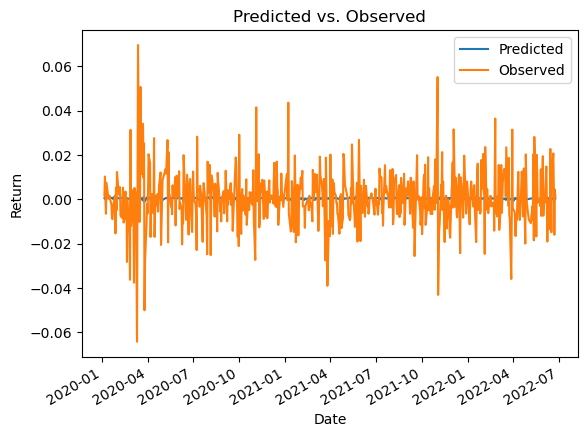

In [46]:
#plot result for month april 2022
plot_results()
plot_results(result[(result["SecuritiesCode"] == 1301) && ()]["predict"], result[result["SecuritiesCode"] == 1301]["Target"])

In [47]:
lgbm_params = {
    'seed': 42,
    'n_jobs': -1,
}

feat_cols = [
    "close_diff1",
]

In [48]:
pred_model = LGBMRegressor(**lgbm_params)
pred_model.fit(train_X[feat_cols].values, train_y)
# prepare result data
result = test_X[["SecuritiesCode"]].copy()
# predict
result.loc[:, "predict"] = pred_model.predict(test_X[feat_cols])
# actual result
result.loc[:, "Target"] = test_y.values
print(compute_mse(result["predict"], result["Target"]))

0.000645370840390431


In [49]:
print(test_X)

            SecuritiesCode  close_diff1
Date                                   
2020-01-06            1301        -13.0
2020-01-07            1301         36.0
2020-01-08            1301          5.0
2020-01-09            1301         30.0
2020-01-10            1301         -1.0
...                    ...          ...
2022-06-20            9997         -6.0
2022-06-21            9997         19.0
2022-06-22            9997          1.0
2022-06-23            9997          0.0
2022-06-24            9997         12.0

[1202713 rows x 2 columns]


In [50]:
print(test_y)

Date
2020-01-06    0.001725
2020-01-07    0.010338
2020-01-08   -0.000341
2020-01-09   -0.006481
2020-01-10    0.007553
                ...   
2022-06-20    0.001416
2022-06-21    0.000000
2022-06-22    0.016968
2022-06-23    0.013908
2022-06-24    0.015091
Name: label, Length: 1202713, dtype: float16


In [51]:
#baseline
def moving_3month_pred(series, n_preds):
    data = list(series)
    for i in range(n_preds):
        y0 = np.mean(data[-3:])
        data.append(y0)
    return data[-n_preds:]

In [52]:
#for each security make baseline prediction from 2020-01-06 to 2022-06-24

def get_baseline_prediction(df_price, codes):
    """
    Args:
        df_price (pd.DataFrame): loaded price data
        codes  (array) : target codes
    Returns:
        result (pd.DataFrame): baseline prediction
    """
    result_final = pd.DataFrame()
    result = []
    for code in tqdm(codes):
        df = df_price.loc[df_price["SecuritiesCode"] == code].copy()
        new_results = moving_3month_pred(df["close_diff1"], 604)
        #let's add new_result to result
        result = result + new_results
    result_final.loc[:, "predict"] = result
    result_final.loc[:, "Target"] = test_y.values
    return result

In [53]:
test_y.shape

(1202713,)

In [54]:
codes = sorted(df_price["SecuritiesCode"].unique())
print(len(codes))

2000


In [55]:
codes = sorted(df_price["SecuritiesCode"].unique())
print(len(codes))
result = get_baseline_prediction(train_X, codes)


2000


  0%|          | 0/2000 [00:00<?, ?it/s]c:\Anaconda\envs\OR_env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Anaconda\envs\OR_env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2000/2000 [01:23<00:00, 23.84it/s]


ValueError: Length of values (1202713) does not match length of index (1208000)

In [ ]:
#Let's build a new dataset from df_price with as features the value of close_diff1 at d-1 to d-7, m-1 to m-3, y-1 to y-3

def build_new_df(df_price, d=[1, 2, 3, 4, 5, 6 7], m=[1, 2, 4], y=[1, 2 3]):
    """
    Args:
        df_price (pd.DataFrame): loaded price data
        d  (array) : days
        m  (array) : months
        y  (array) : years
    Returns:
        df_new (pd.DataFrame): new dataframe
    """
    df_new = pd.DataFrame()
    for code in tqdm(codes):
        df = df_price.loc[df_price["SecuritiesCode"] == code].copy()
        for day in d:
            df.loc[:, "close_diff1_d{}".format(day)] = df["close_diff1"].shift(day)
        for month in m:
            df.loc[:, "close_diff1_m{}".format(month)] = df["close_diff1"].shift(month*30)
        for year in y:
            df.loc[:, "close_diff1_y{}".format(year)] = df["close_diff1"].shift(year*365)
    